# Step 0. Initial Google Drive to prepare data

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


#Step 1. Use Python Version Data to Load 

Tensorflow version 1.8.0


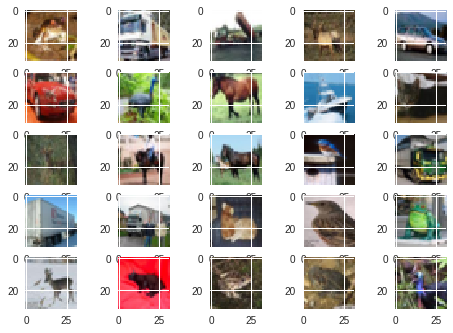

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
(50000, 32, 32, 3) (50000, 10)


In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.platform import gfile
import tarfile
print("Tensorflow version " + tf.__version__)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

dir_data = r'D:\MachineLearning\cifar-10\cifar-10-batches-py'
#dir_data = r'C:\Rasp\Face Recognition\cifar-10'

def cifar_read(dir_data,train_or_test,onehot = True):
    if train_or_test == 1:
        filenames = [os.path.join(dir_data, 'data_batch_%d' % i)for i in range(1, 6)]
    else:
        filenames = [os.path.join(dir_data, 'test_batch')]
    label_s = []
    for i in range(len(filenames)):
        f = open(filenames[i],'rb')
        dic = pickle.load(f,encoding='bytes')
        f.close()
        cnt = len(dic[b'labels'])
        label_s+= dic[b'labels']
        img = dic[b'data'].reshape(10000, 3, 32, 32)
        img = img.transpose(0,2,3,1)
        if i ==0:  img_s = img
        else:      img_s = np.concatenate([img_s,img],axis = 0)
    
    label_s = np.array(label_s).reshape(len(label_s))
    if onehot:
        n_values =  np.max(label_s) + 1
        label_s = np.eye(n_values,dtype = np.float32)[label_s]
    return img_s,label_s


def difar_read_fromtar(dir_data):
    gfile.Exists(dir_data)
    tarfile.open(dir_data +'/cifar-10-python.tar.gz', 'r:gz').extractall(dir_data)
    img_train,label_train = cifar_read(dir_data+r'/cifar-10-batches-py',1)
    img_test,label_test = cifar_read(dir_data+r'/cifar-10-batches-py',0)
    return img_train,label_train,img_test,label_test


def show_img(img,cnt):
    for i in range(cnt):
        plt.subplot(5,5,i+1)
        plt.imshow(img[i])
    plt.show()   
    
    
img_train,label_train,img_test,label_test = difar_read_fromtar('/content/drive/')
#img_train,label_train,img_test,label_test = difar_read_fromtar(dir_data)
show_img(img_train[:25],25)
print(label_train[:25])
print(img_train.shape,label_train.shape)

img_train_float = img_train/255.
img_test_float = img_test/255.



In [2]:
item = 0
def next_batch(x,y,batch_size):
    global item
    while True:
        item += batch_size
        if item+2*batch_size > x.shape[0]:   item = 0
        return x[item:item+batch_size,:],y[item:item+batch_size,:]
    
permutation = np.random.permutation(img_train.shape[0])
shuffled_img = img_train_float[permutation, :]
shuffled_labels = label_train[permutation, :]

print(shuffled_img.shape, shuffled_labels.shape,img_train.dtype,label_train.dtype)
print(img_test.shape, label_test.shape)


(50000, 32, 32, 3) (50000, 10) uint8 float32
(10000, 32, 32, 3) (10000, 10)


# Step 2. Set up learning model, train the network and save checkpoint

In [3]:
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 32, 32, 3],name = 'Input')
# correct answers will go here
Y_LABEL = tf.placeholder(tf.float32, [None, 10],name = 'Label')
# variable learning rate
lr = tf.placeholder(tf.float32)
# test flag for batch norm
iftraining = tf.placeholder(tf.bool,name = 'Mode')
# dropout probability


def batch_normal(X,iftraining):
    return  tf.layers.batch_normalization(X, training=iftraining)


def hidden_cnn_layer(X, sizeOutput,kernal, stride, activation = 'sigmoid',bn_enable = False,iftraining = True):
    W = tf.Variable(tf.truncated_normal([int(kernal), int(kernal), int(X.shape[-1]), int(sizeOutput)], stddev=0.001))
    Y = tf.nn.conv2d(X, W, strides=[1, int(stride), int(stride), 1], padding='SAME')
    if bn_enable:    Y_bn = batch_normal(Y, iftraining)
    else:            Y_bn = Y
    if activation == 'sigmoid':    A = tf.nn.sigmoid(Y_bn)
    elif activation == 'relu':     A = tf.nn.relu(Y_bn)
    else:                          A = Y_bn
      
    return A
         

def hidden_maxpool_layer(X,pool_size,strides,padding='SAME'):
    return tf.layers.max_pooling2d(X,pool_size,strides,padding)
  

def hidden_fc_layer(X,sizeOutput,activation = '',bn_enable = False,iftraining = True):
    W = tf.Variable(tf.truncated_normal([int(X.shape[-1]), sizeOutput], stddev=0.001))
    if bn_enable == False:
        B = tf.Variable(tf.zeros(sizeOutput))   #Not necessary in bn as offset exists
        Y = tf.matmul(X,W) + B
    else:         
        Y_linear = tf.matmul(X,W)
        Y = batch_normal(Y_linear, iftraining)

    if activation == 'sigmoid':     A = tf.nn.sigmoid(Y)
    elif activation == 'relu':      A = tf.nn.relu(Y)
    else:                           A = Y

    return A

A1 = hidden_cnn_layer(X, sizeOutput=128, kernal=5, stride=1, activation ='relu', bn_enable=True, iftraining = iftraining)
A1_pool = hidden_maxpool_layer(A1,pool_size=[2, 2], strides=2)
A2 = hidden_cnn_layer(A1_pool,sizeOutput=256, kernal=5, stride=1, activation ='relu', bn_enable=True, iftraining = iftraining)
A2_pool = hidden_maxpool_layer(A2,pool_size=[2, 2], strides=2)
A3 = hidden_cnn_layer(A2_pool,sizeOutput=512, kernal=5, stride=1, activation ='relu', bn_enable=True, iftraining = iftraining)
A4 = hidden_cnn_layer(A3,sizeOutput=512, kernal=5, stride=1, activation ='relu', bn_enable=True, iftraining = iftraining)
A5 = hidden_cnn_layer(A4,sizeOutput=256, kernal=5, stride=1, activation ='relu', bn_enable=True, iftraining = iftraining)
A5_pool = hidden_maxpool_layer(A5,pool_size=[3, 3], strides=2)

size = 1
for i in range(1,len(A5_pool.shape)):     size*= int(A5_pool.shape[i])
print(size)
A5_pool_reshape = tf.reshape(A5_pool,[-1,size])
print(A5_pool_reshape.shape)
print(A5_pool.shape)
A6 = hidden_fc_layer(A5_pool_reshape,sizeOutput = 2048,activation ='relu', bn_enable=True, iftraining = iftraining)
A7 = hidden_fc_layer(A6,sizeOutput = 1024,activation ='relu', bn_enable=True, iftraining = iftraining)
Y_linear = hidden_fc_layer(A7,sizeOutput = 10)
Y_predict       = tf.nn.softmax(Y_linear,name = 'Y_predict')


cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=Y_LABEL, logits=Y_linear))*100
optimizer = tf.train.AdamOptimizer(lr)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = optimizer.minimize(cross_entropy)

4096
(?, 4096)
(?, 4, 4, 256)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [5]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

max_learning_rate = 0.2
min_learning_rate = 0.0001
decay_speed = 5000.0

import time
time_start=time.time()    #1970.1.1开始到现在的秒数

saver = tf.train.Saver()   
for _ in range(10000+1):
    batch_xs, batch_ys = next_batch(shuffled_img,shuffled_labels,256)
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * np.exp(-_/decay_speed)
    sess.run(train_step, feed_dict={X: batch_xs, Y_LABEL: batch_ys, lr: learning_rate, iftraining: True},options=run_opts)

    if _%100 == 0:  
        correct_prediction = tf.equal(tf.argmax(Y_linear, 1), tf.argmax(Y_LABEL, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print(_, sess.run(accuracy, feed_dict={X: img_test_float[0:600], Y_LABEL: label_test[0:600], iftraining: True}))
        saver.save(sess, "./Model_CIFAR10/CNN_bn.ckpt",global_step= _ )

time_end=time.time()
print('totally cost (s)',time_end-time_start)

sess.close()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0 0.11
100 0.135
200 0.21
300 0.24
400 0.24333334
500 0.18833333
600 0.27
700 0.31666666
800 0.35
900 0.43833333
1000 0.44333333
1100 0.42666668
1200 0.50333333
1300 0.6
1400 0.595
1500 0.6
1600 0.655
1700 0.66333336
1800 0.6933333
1900 0.685
2000 0.72
2100 0.6983333
2200 0.725
2300 0.72833335
2400 0.7416667
2500 0.72
2600 0.73333335
2700 0.74833333
2800 0.71
2900 0.74833333
3000 0.75333333
3100 0.75333333
3200 0.73833334
3300 0.74
3400 0.7583333
3500 0.7733333
3600 0.75
3700 0.785
3800 0.745
3900 0.7783333
4000 0.76166666
4100 0.7783333
4200 0.7816667
4300 0.7633333
4400 0.7783333
4500 0.7866667
4600 0.7916667
4700 0.76666665
4800 0.785
4900 0.80333334
5000 0.795
5100 0.795
5200 0.785
5300 0.775
5400 0.785
5500 0.79333335
5600 0.785
5700 0.79
5800 0.7966667
5900 0.7866667
6000 0.79333335
6100 0.79333335
6200 0.7966667
6300 0.7966667
6400 0.7866667
6500 0.79
6600 0.8016667
6700 0.79833335
6800 0.8
6900 0.7966667
7000 0.795
7100 0.79333335
7200 0.80333334
7300 0.8016667
7400 0.79333335


# Step 3. Freeze learning model. Use checkpoint file to generate pb file

In [3]:
import tensorflow as tf
with tf.Session() as sess:

    #初始化变量
    sess.run(tf.global_variables_initializer())

    #获取最新的checkpoint，其实就是解析了checkpoint文件
    latest_ckpt = tf.train.latest_checkpoint("./Model_CIFAR10")

    #加载图
    restore_saver = tf.train.import_meta_graph('./Model_CIFAR10/CNN_bn.ckpt-10000.meta')

    #恢复图，即将weights等参数加入图对应位置中
    restore_saver.restore(sess, latest_ckpt)

    #将图中的变量转为常量
    output_graph_def = tf.graph_util.convert_variables_to_constants(
        sess, sess.graph_def , ["Y_predict"])
    #将新的图保存到"/pretrained/graph.pb"文件中
    tf.train.write_graph(output_graph_def, 'pretrained', "graph.pb", as_text=False)

OSError: ignored

# Step 4. Prediction: Test batch size increase from 1

[3]
[3 1]
[3 1 8]
[3 1 8 0]
[3 1 8 0 4]
[3 1 8 0 4 6]
[3 1 8 0 4 6 1]
[3 1 8 0 4 6 1 3]
[3 1 8 0 4 6 1 3 3]
[3 1 8 0 4 6 1 3 3 1]
[3 1 8 0 4 6 1 3 3 1 0]
[3 1 8 0 4 6 1 3 3 1 0 9]
[3 1 8 0 4 6 1 3 3 1 0 9 5]
[3 1 8 0 4 6 1 3 3 1 0 9 5 7]
[3 1 8 0 4 6 1 3 3 1 0 9 5 7 1]
[3 1 8 0 4 6 1 3 3 1 0 9 5 7 1 8]
[3 1 8 0 4 6 1 3 3 1 0 9 5 7 1 8 5]
[3 1 8 0 4 6 1 3 3 1 0 9 5 7 1 8 5 7]
[3 1 8 0 4 6 1 3 3 1 0 9 5 7 1 8 5 7 1]
[3 1 8 0 4 6 1 3 3 1 0 9 5 7 1 8 5 7 1 6]
[3 1 8 0 4 6 1 3 3 1 0 9 5 7 1 8 5 7 1 6 7]
[3 1 8 0 4 6 1 3 3 1 0 9 5 7 1 8 5 7 1 6 7 0]
[3 1 8 0 4 6 1 3 3 1 0 9 5 7 1 8 5 7 1 6 7 0 0]
[3 1 8 0 4 6 1 3 3 1 0 9 5 7 1 8 5 7 1 6 7 0 0 9]
[3 1 8 0 4 6 1 3 3 1 0 9 5 7 1 8 5 7 1 6 7 0 0 9 4]


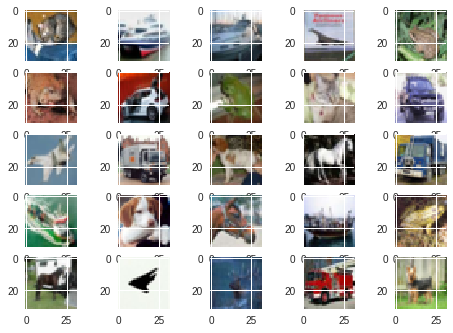

[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5]


In [8]:
import numpy as np
import tensorflow as tf


def recognize(img_input, pb_file_path):
    with tf.Graph().as_default():
        output_graph_def = tf.GraphDef()

        with open(pb_file_path, "rb") as f:
            output_graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(output_graph_def, name="")

        with tf.Session() as sess:
            init = tf.global_variables_initializer()
            sess.run(init)

            input_x = sess.graph.get_tensor_by_name("Input:0")
            # print input_x
            mode = sess.graph.get_tensor_by_name('Mode:0')
            out_softmax = sess.graph.get_tensor_by_name("Y_predict:0")
            
            img_try = img_input
            test_input = np.float32(img_try)
            img_out_softmax = sess.run(out_softmax, feed_dict={input_x:test_input,mode: False})
            prediction_labels = np.argmax(img_out_softmax, axis=1)
            return prediction_labels


start = 0
for i in range(1,26):
    r = recognize(img_test_float[start:start+i], "./pretrained/graph.pb")
    print(r)

show_img(img_test[start:start+25],25)
print(np.argmax(label_test[start:start+25],axis = 1) )

# Step 5. Plot the test results

In [0]:
import matplotlib.pyplot as plt
for i in range(25):
    plt.subplot(5,5,i+1)
    image_data = mnist.test.images[start+i].reshape([28,28])
    image = plt.imshow(image_data,cmap=plt.get_cmap('gray_r'))
plt.show()
result_s = np.argmax(mnist.test.labels[start:start+25],1)
print(result_s)
